# COMPSCI 760 PB3 

In [1]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler

### Alter those 3 parameters to see the effect on the model

In [2]:
TRAINING_LENGTH = 5 #MLP
# 5 weeks for training and predict the next week

TARGET_STOCK_ID = 2 # 0 indicates 'ADA'
# The Stock ID for model prediction range from 0 to 36
# stock name list : ['ADA', 'BNB', 'BTC', 'DOGE', 'EOS', 'ETC', 'ETH', 'LTC', 'XRP', 'AAPL', 'AMZN',
#'ARKK', 'BAC', 'F', 'FB', 'GE', 'GOOGL', 'HD', 'JPM', 'MA', 'MSTR', 'PYPL', 'SQ', 
#'T', 'TSLA', 'UNH', 'V', 'VYGR', 'WFC', 'WMT', 'XOM', 'BZ=F', 'DX-Y.NYB', 'GC=F', 
#'^DJI', '^GSPC', '^TNX']

READ_COLUMNS =  ["Date", "Open", "High", "Low", "Close"]
# List of names for columns of data fed into the model
# READ_COLUMNS = ["Date", "Open", "High", "Low", "Close", "Volume"]

## Import Data

In [3]:
#Read in all Data
def read_data(file_paths, read_cols):
    all_data = pd.DataFrame()
    file_index = 0
    names = []
    
    for files in file_paths:
        for f in files:
            if file_index == 0:
                csv = pd.read_csv(f, usecols = read_cols)
                names.append(str(f)[17:-4])
                for col in read_cols[1:]:
                    csv.rename(columns={col : col + " " + str(f)[17:-4]}, inplace=True)
                all_data = all_data.append(csv)
            else:
                csv = pd.read_csv(f, usecols = read_cols)
                if file_paths.index(files) == 2:
                    names.append(str(f)[22:-4])
                    for col in read_cols[1:]:
                        csv.rename(columns={col : col + " " + str(f)[22:-4]}, inplace=True)
                else:
                    names.append(str(f)[17:-4])
                    for col in read_cols[1:]:
                        csv.rename(columns={col : col +  " " + str(f)[17:-4]}, inplace=True)
                all_data = pd.merge(all_data, csv, on = "Date", how = "outer")
            file_index += 1
    all_data["Date"] = pd.to_datetime(all_data["Date"])
    
    for c in all_data.columns[1:]: # Tidy data
        all_data[c] = all_data[c].astype(float)
    
    all_data.fillna(method="pad", inplace=True) # Replace Missing Value with last day's value
    
    return all_data, names

def clean_data(all_data):
    drop_indices = [ind for ind in range(all_data.shape[0]) if (ind + 1) % 7 != 1]
    # "if (ind + 1) % 7 != 1" 1 here indicates select Monday and drop the others
    all_data.drop(drop_indices, inplace=True)
    all_data = all_data.reset_index(drop=True)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range = (-1, 1))
    for col in all_data.columns[1:]:
        all_data[col] = scaler.fit_transform(all_data[col].values.reshape(-1,1))
    return all_data

In [4]:
file_paths = [glob.glob("./Dataset/Crypto/*.csv"), glob.glob("./Dataset/Stocks/*.csv"), glob.glob("./Dataset/Commodities/*.csv")]
feature_num = len(READ_COLUMNS) - 1
all_data, names = read_data(file_paths, READ_COLUMNS)
#all_data.head(all_data.shape[0])

all_data = clean_data(all_data)
all_data.isnull().values.any() # Returns False if there is no Missing Value
#all_data.head(all_data.shape[0])

False

## Model

In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

### Model Input

In [6]:
def create_input_graph_set(data, nodes_num):
    result_graphs = []
    edge_list = []
    features_num = int((data.shape[1] - 1) // nodes_num)
    # connect all nodes with the other and it self
    for ei in range(nodes_num):
        for ej in range(nodes_num):
            edge_list.append([ei, ej])
    edge_index = torch.tensor(edge_list, dtype=torch.long)
    
    for r in range (data.shape[0]):
        row = list(data.iloc[r])
        features = []
        for f in range(int((len(row)-1) / features_num)):
            features.append(row[1 + f * features_num : 1 + (f + 1) * features_num])
        x = torch.tensor(features, dtype=torch.float)
        result_graphs.append(Data(x = x, edge_index = edge_index.t().contiguous()))
    return result_graphs

In [7]:
input_graphs = create_input_graph_set(all_data, len(names))
data_length = len(input_graphs)
print(data_length)

105


In [8]:
def get_all_y_and_train_y(data, stock_names, training_length, target_id):
    all_y = pd.DataFrame()
    for n in stock_names:
        used_col = str("Close " + n)
        all_y[used_col + " Next not ROI"] = data[used_col]
        #all_y = all_y.pct_change()
        #all_y = all_y * 100
    all_y.insert(0, "Date", data['Date'][1:])
    #all_y = all_y.iloc[1:, :]
    #all_y = all_y.reset_index(drop=True)
    
    y = all_y.iloc[training_length : , target_id+1:target_id+2]
    return all_y, torch.tensor(y.values).float()

In [9]:
all_y, y= get_all_y_and_train_y(all_data, names, TRAINING_LENGTH, TARGET_STOCK_ID)
#all_y.head(all_y.shape[0])
print(all_y.shape)
print(y.shape)

(105, 38)
torch.Size([100, 1])


### Graph Attention Network and Long Short-Term Memory

In [10]:
class GATandLSTM(torch.nn.Module):
    def __init__(self, graph_num, stock_num, feature_num, target_stock_id, training_length, device):
        super(GATandLSTM, self).__init__()
        self.device = device
        self.training_length = training_length
        self.target_id = target_stock_id  # stock id for prediction
        self.num_nodes = stock_num
        # GAT
        self.gat_num = graph_num
        self.gat_features = feature_num
        self.gat_hid = 32 #8
        self.gat_in = 8 
        self.gat_out = 1 
        
        
        self.gat_conv1 = GATConv(self.gat_features, self.gat_hid , heads=self.gat_in, dropout=0.05)
        self.gat_conv2 = GATConv(self.gat_hid*self.gat_in, self.gat_out, concat=False,
                             heads=self.gat_out, dropout=0.05)
        #LSTM
        self.lstm_features = self.gat_out
        self.lstm_hid = 32 #8
        self.lstm_seq_len = self.training_length
        self.lstm_lay = 2
        self.lstm_out = 1
        
        self.lstm = nn.LSTM(input_size=self.lstm_features, hidden_size=self.lstm_hid, 
                            num_layers=self.lstm_lay,batch_first = True, dropout=0.05)
        self.lin = nn.Linear(self.lstm_hid, self.lstm_out)
        
    
    #def reset_hidden_state(self):
        #self.hidden = (
            #torch.zeros(self.lstm_lay, self.lstm_seq_len, self.lstm_hid),
            #torch.zeros(self.lstm_lay, self.lstm_seq_len, self.lstm_hid)
        #)
        
    
    def forward(self, data):
        output = []
        
        # GAT forward
        for t in range(self.gat_num):
            x, edge_index = data[t].x, data[t].edge_index
            x = self.gat_conv1(x, edge_index)
            x = F.elu(x)
            x = self.gat_conv2(x, edge_index)
            if t == 0:
                xs_out = x.T
            else:
                xs_out = torch.cat((xs_out, x.T), 0)
        
        # LSTM forward
        sequences = xs_out.T
        time_series = self.split_sequences(sequences, self.training_length, self.target_id)
        #print(time_series.shape)
        h0 = torch.zeros(self.lstm_lay, time_series.size(0), self.lstm_hid).to(self.device).requires_grad_()
        c0 = torch.zeros(self.lstm_lay, time_series.size(0), self.lstm_hid).to(self.device).requires_grad_()
            
        lstm_out, (hn, cn) = self.lstm(time_series, (h0.detach(), c0.detach()))
        #print(lstm_out)
        pred = self.lin(lstm_out[:, -1,:])
        #print(pred.shape)
        return pred

    def split_sequences(self, sequences, training_length, target_id):
        ts_raw = sequences[target_id].detach().to('cpu').numpy()
        ts = []
        for i in range(len(ts_raw) - training_length): 
            ts.append(ts_raw[i : i + training_length])
        ts = np.array(ts)
        ts = ts.reshape(ts.shape[0],ts.shape[1], 1)
        return torch.from_numpy(ts).type(torch.Tensor).to(self.device)

### Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

loss_list = []

model = GATandLSTM(data_length, len(names), feature_num, TARGET_STOCK_ID, TRAINING_LENGTH, device).to(device)
for graph in input_graphs:
    graph = graph.to(device)


#optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#optimizer = torch.optim.SGD(model.parameters(), lr =0.005 )

model.train()
for epoch in range(200):
    model.train()
    out = model(input_graphs)
    mse_loss = nn.MSELoss(reduction = "mean")
    loss = mse_loss(out, y.to(device))
    loss_list.append(loss.item())
    #if epoch % 50 == 0:
        #print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

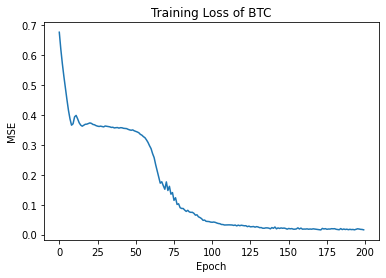

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training Loss of " +str(names[TARGET_STOCK_ID]))
plt.show()

#### Ground truth

In [13]:
print(y.T)

tensor([[-0.7520, -0.7678, -0.7853, -0.8051, -0.8063, -0.8076, -0.8095, -0.8295,
         -0.8811, -0.8847, -0.8789, -0.8844, -0.8477, -0.8408, -0.8649, -0.8848,
         -0.9241, -0.9174, -0.9158, -0.9321, -0.9165, -0.9191, -0.9005, -0.8876,
         -0.8682, -0.8585, -0.8445, -0.8241, -0.8294, -0.8312, -0.8582, -0.8942,
         -1.0000, -0.9475, -0.9502, -0.9161, -0.9340, -0.9344, -0.8999, -0.8598,
         -0.8711, -0.8284, -0.8588, -0.8114, -0.8266, -0.8396, -0.8301, -0.8481,
         -0.8426, -0.8463, -0.8493, -0.7811, -0.7742, -0.7496, -0.7355, -0.7549,
         -0.7585, -0.8051, -0.7942, -0.8035, -0.7933, -0.7898, -0.7629, -0.7548,
         -0.7073, -0.6892, -0.6243, -0.5738, -0.5134, -0.4650, -0.4843, -0.4804,
         -0.3547, -0.1957, -0.0166,  0.1080,  0.1527, -0.0069,  0.0395,  0.5081,
          0.5642,  0.7895,  0.6253,  0.7270,  0.8448,  0.7893,  0.9189,  0.9734,
          1.0000,  0.8458,  0.7863,  0.9019,  0.8525,  0.4046,  0.2317,  0.1754,
          0.0404,  0.2944, -

#### Model Prediction

In [14]:
m = model(input_graphs)
print(m.T)

tensor([[-0.8164, -0.8064, -0.8274, -0.8342, -0.8151, -0.8501, -0.8437, -0.8305,
         -0.8371, -0.8436, -0.8485, -0.8430, -0.8422, -0.8299, -0.8458, -0.8440,
         -0.8186, -0.8265, -0.8286, -0.7993, -0.8279, -0.8150, -0.7916, -0.7553,
         -0.6941, -0.7283, -0.6490, -0.7370, -0.6372, -0.7487, -0.7972, -0.7427,
         -0.7266, -0.8336, -0.8502, -0.8549, -0.8362, -0.8408, -0.8527, -0.8538,
         -0.8523, -0.8484, -0.8462, -0.8386, -0.8481, -0.8472, -0.8202, -0.8460,
         -0.8562, -0.8433, -0.8486, -0.8459, -0.8379, -0.8446, -0.8450, -0.8467,
         -0.8450, -0.8123, -0.8236, -0.8196, -0.7658, -0.7886, -0.8411, -0.8306,
         -0.8362, -0.8274, -0.7975, -0.7575, -0.7947, -0.8204, -0.8133, -0.6002,
         -0.5360, -0.4486, -0.1124,  0.0471,  0.0042,  0.0207,  0.2570,  0.3834,
          0.5061,  0.5943,  0.6149,  0.6239,  0.9033,  0.9133,  0.9009,  0.9106,
          0.8900,  0.7508,  0.8250,  0.7776,  0.5023,  0.2457,  0.2710,  0.1988,
          0.0525,  0.0725,  

### Pred vs Ground Truth

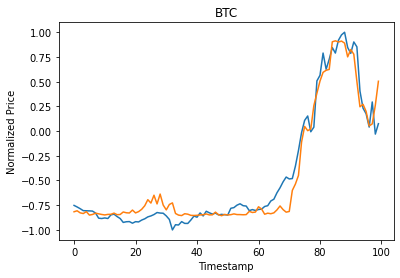

In [15]:
plt.plot(y.T.numpy().reshape(y.shape[0])) # blue line is Ground Truth
plt.plot(m.T.detach().to('cpu').numpy().reshape(y.shape[0])) # orange line is model prediction
plt.xlabel("Timestamp")
plt.ylabel("Normalized Price")
plt.title(names[TARGET_STOCK_ID])
plt.show()

In [16]:
print(loss.item())

0.015922555699944496


In [17]:
# Different LSTM for different type of data
# Transform input feature e.g. MLP
# Visualize attention weights distinguishable between two timestamp
# Baseline only LSTM